# BERT
___

This model is based on:

```Bibtex
@article{toledo-ronenMultilingualArgumentMining2020,
  title = {Multilingual Argument Mining: {{Datasets}} and Analysis},
  author = {Toledo-Ronen, Orith and Orbach, Matan and Bilu, Yonatan and Spector, Artem and Slonim, Noam},
  date = {2020},
  url = {https://arxiv.org/abs/2010.06432},
}
```

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')  # connect to google drive
base_dir = "drive/MyDrive/claim_model_comparison"

Mounted at /content/drive


In [1]:
%%capture
! pip install transformers
! pip install wandb

In [57]:
import os
import pandas as pd
import numpy as np
import random
import timeit
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score


from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf

import wandb
from wandb.keras import WandbCallback


In [37]:
def load_dataset(dataset_path: str, split_size: float=0.2, false_class_balance: float=1.0) -> pd.DataFrame:
    """Function to load the dataset.

    Returns:
        X_train (DatFrame): Train data
        X_test (DatFrame): Test data
        y_train (DatFrame): Train label
        y_test (DatFrame): Test label
    """
    data = pd.read_csv(os.path.join(dataset_path))  # load Data

    claims = data[data["Claim"] == True]

    n_samples = int(len(claims) * false_class_balance)
    no_claims = data[data["Claim"] == False].sample(n=n_samples, random_state=42)
    data_sample = pd.concat([claims, no_claims])

    X_train, X_test, y_train, y_test = train_test_split(
        data_sample, data_sample["Claim"], test_size=split_size, random_state=0
    )
    return X_train, X_test, y_train, y_test

In [38]:
MODEL_NAME = "distilbert-base-uncased"
TRACKING = True
FALSE_CLASS_BALANCE = 1.0
DATASET_2014_PATH = os.path.join(base_dir, "CE-ACL_processed.csv")
DATASET_2018_PATH = os.path.join(base_dir, "claim_sentence_search.csv")
DATASET_2014_NAME = "IBM_Debater_(R)_CE-ACL-2014.v0"
DATASET_2018_NAME = "IBM_Debater_(R)_claim_sentences_search"
PROJECT_NAME = "Claim detection models"

### 0. Load data

In [39]:
train_text_split, X_test, train_labels_split, y_test = load_dataset(dataset_path=DATASET_2014_PATH, false_class_balance=FALSE_CLASS_BALANCE)

In [40]:
y_train = train_labels_split.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(train_text_split, train_labels_split, test_size=.2, random_state=42) # train/test

### 1. Prepare dataset

In [42]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # load tokenizer

In [43]:
def tokenize_dataset(dataset):
    """Tokenize a list of strings for the BERT model."""
    encoded = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

In [44]:
encodet_train_text = tokenize_dataset(X_train["Sentence"].to_list())
encodet_val_texts = tokenize_dataset(X_val["Sentence"].to_list())
encodet_test_texts = tokenize_dataset(X_test["Sentence"].to_list())

### 2. Create Model

In [45]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Load model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [46]:
# Set hyperparameter
learning_rate = 5e-5
epochs = 5
batch_size = 16

In [60]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_99', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [61]:
model.compile(
    optimizer=optimizer, 
    loss=model.compute_loss,
    metrics=tf.metrics.SparseCategoricalAccuracy(),
    )

In [62]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### 3. Train model

In [63]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": DATASET_2014_NAME,
              "train_data_size": len(X_train),
              "validation_data_size": len(X_val),
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": learning_rate,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

In [64]:
history = model.fit(
      encodet_train_text,
      np.array(y_train), 
      validation_data=(encodet_val_texts, np.array(y_val)),
      epochs=epochs, 
      batch_size=batch_size,
      callbacks=[WandbCallback()])

stop = timeit.default_timer()

Epoch 1/5
99/99 [==============================] - ETA: 0s - loss: 0.5136 - sparse_categorical_accuracy: 0.7568

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


99/99 [==============================] - 90s 781ms/step - loss: 0.5136 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.4958 - val_sparse_categorical_accuracy: 0.7671
Epoch 2/5
99/99 [==============================] - 74s 749ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.5216 - val_sparse_categorical_accuracy: 0.7595
Epoch 3/5
99/99 [==============================] - 74s 750ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.6259 - val_sparse_categorical_accuracy: 0.8076
Epoch 4/5
99/99 [==============================] - 74s 751ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.7924
Epoch 5/5
99/99 [==============================] - 74s 751ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.9283 - val_sparse_categorical_accuracy: 0.7646


### 4. Evaluate results

In [65]:
test_loss, test_accuracy = model.evaluate(encodet_test_texts, np.array(y_test))

16/16 [==============================] - 7s 340ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.8198


In [66]:
preds = model.predict(encodet_test_texts)

In [67]:
y_pred = np.argmax(preds.logits, axis=1)

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       235
           1       0.81      0.86      0.83       259

    accuracy                           0.82       494
   macro avg       0.82      0.82      0.82       494
weighted avg       0.82      0.82      0.82       494



In [69]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [70]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

epoch,▁▃▅▆█
loss,█▅▂▁▁
sparse_categorical_accuracy,▁▅▇██
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_loss,▁▁▃▅█
val_sparse_categorical_accuracy,▂▁█▆▂
best_epoch,0
best_val_loss,0.49584


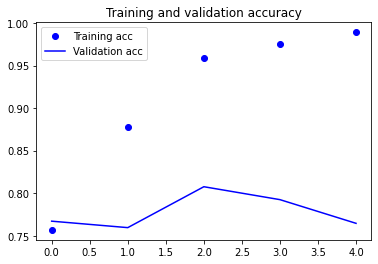

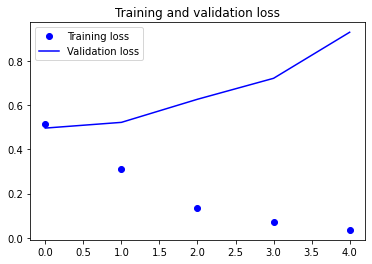

In [74]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()